### Problem Statement

**Overview:**  

In this project, you will work with customer complaints submitted to the Consumer Financial Protection Bureau (CFPB) regarding various financial products. Your task is to build an NLP classification model that can automatically categorize complaints based on the provided textual narratives. The classification will help financial institutions resolve complaints more efficiently by routing them to the appropriate teams for quicker handling.

The dataset contains customer complaints categorized into five product classes: credit reporting, debt collection, mortgages and loans, credit cards, and retail banking. These narratives are often raw and noisy, requiring significant preprocessing to develop a model capable of accurate classification.


### DAY 1

Today's Goals :
- Basic understanding of the dataset
- Data cleaning
- Data preprocessing (maybe! if i get time)

### Lets get familiar with our dataset

### Importing the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Importing the dataset

In [2]:
dataframe = pd.read_csv('./Datasets/complaints.csv')

In [3]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162421 entries, 0 to 162420
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  162421 non-null  int64 
 1   product     162421 non-null  object
 2   narrative   162411 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [4]:
print(dataframe['product'].unique())

['credit_card' 'retail_banking' 'credit_reporting' 'mortgages_and_loans'
 'debt_collection']


-  an Unnamed column which is the Complaint Number: The dataset has a unique complaint number for each complaint. we got our ID!

-  Product: This is our target variable, which is categorized into five classes:
    - Credit cards
    - Retail banking
    - Credit reporting
    - Mortgages and loans
    - Debt collection

- Narrative: This is the narrative of customers' complaints. Obvisously, this is the most important feature for our analysis.

In [5]:
dataframe.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


The columns are not named properly, so we will rename them

In [8]:
""" 
# rename the Unnamed: 0 column to id
# rename the product column to class
# rename the narrative column to complaint
"""

dataframe.rename(columns={'Unnamed: 0': 'id', 'product': 'class', 'narrative': 'complaint'}, inplace=True)

In [9]:
dataframe.head()

,id,class,complaint
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [10]:
# set the id column as the index
dataframe.set_index('id', inplace=True)

In [11]:
dataframe.head()

,class,complaint
id,,
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


In [12]:
print(dataframe['class'].unique())

['credit_card' 'retail_banking' 'credit_reporting' 'mortgages_and_loans'
 'debt_collection']


### Lets Clean the data if required (obviously it will be required)

checking Null values

In [13]:
dataframe.isna().sum()

class         0
complaint    10
dtype: int64

great! just 10 null values in the dataset. We can definitely drop them.

But lets take a look at them

In [14]:
print(dataframe[dataframe.isnull().any(axis=1)])

                   class complaint
id                                
1089    credit_reporting       NaN
3954    credit_reporting       NaN
3955    credit_reporting       NaN
29690   credit_reporting       NaN
139436   debt_collection       NaN
151052   debt_collection       NaN
154494  credit_reporting       NaN
156902    retail_banking       NaN
158538  credit_reporting       NaN
159503  credit_reporting       NaN


In [15]:
dataframe = dataframe.dropna()

In [16]:
dataframe.isna().sum()

class        0
complaint    0
dtype: int64

### Handling the duplicates in the dataset

apart from the null values, we also have to handle the duplicates in the dataset if any.

In [17]:
dataframe.tail()

,class,complaint
id,,
162416,debt_collection,name
162417,credit_card,name
162418,debt_collection,name
162419,credit_card,name
162420,credit_reporting,name


wait a minute! okay lets get rid of these rows which just have 'name' as the complaint.

In [18]:
# get rid of the rows where the complaint is just 'name'
dataframe = dataframe[dataframe['complaint'] != 'name']

In [19]:
# check for duplicates
print(dataframe.duplicated().sum())

37732


In [20]:
dataframe = dataframe.drop_duplicates(keep='first')

In [21]:
dataframe.duplicated().sum()

np.int64(0)

In [22]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124673 entries, 0 to 162414
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   class      124673 non-null  object
 1   complaint  124673 non-null  object
dtypes: object(2)
memory usage: 2.9+ MB


In [23]:
dataframe.tail()

,class,complaint
id,,
162410,credit_reporting,zales comenity bank closed sold account report...
162411,retail_banking,zelle suspended account without cause banking ...
162412,debt_collection,zero contact made debt supposedly resolved fou...
162413,mortgages_and_loans,zillow home loan nmls nmls actual quote provid...
162414,debt_collection,zuntafi sent notice willing settle defaulted s...


### Lets clean the dataset using regex, remove stopwords and maybe try stemming

In [24]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [25]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.remove('not')
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mehmood/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'',text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = ' '.join(ps.stem(word) for word in text.split() if word not in stop_words)
    return text

In [27]:
dataframe['cleaned_complaint'] = dataframe['complaint'].apply(clean_text)

In [ ]:
dataframe.drop('complaint', axis=1, inplace=True)

In [30]:
dataframe.head()

,class,cleaned_complaint
id,,
0,credit_card,purchas order day ship amount receiv product w...
1,credit_card,forward messag date tue subject pleas investig...
2,retail_banking,forward messag cc sent friday pdt subject fina...
3,credit_reporting,payment histori miss credit report special loa...
4,credit_reporting,payment histori miss credit report made mistak...


Now i will save the cleaned dataset because i dont want to spend 5 minutes everytime i run the notebook

In [31]:
# save the cleaned data

dataframe.to_csv('./Datasets/cleaned_complaints.csv')

### Now i am going to speedrun the prediction for DAY 1 just to check if only data cleaning will give me good results

### Else we will obviously have to analyse the dataset to find for imbalances, outliers etc

In [29]:
""" # encode the class column
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
dataframe['class'] = le.fit_transform(dataframe['class']) """

" # encode the class column\nfrom sklearn.preprocessing import LabelEncoder\n\nle = LabelEncoder()\ndataframe['class'] = le.fit_transform(dataframe['class']) "

In [30]:
""" dataframe.head() """

' dataframe.head() '

In [31]:
""" from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(dataframe['cleaned_complaint'])
y = dataframe['class'] """

" from sklearn.feature_extraction.text import TfidfVectorizer\nvectorizer = TfidfVectorizer(max_features=5000)\nX = vectorizer.fit_transform(dataframe['cleaned_complaint'])\ny = dataframe['class'] "

In [32]:
""" from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) """

' from sklearn.model_selection import train_test_split\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) '

In [33]:
""" from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred)) """

' from sklearn.naive_bayes import MultinomialNB\nnb = MultinomialNB()\nnb.fit(X_train, y_train)\n\ny_pred = nb.predict(X_test)\n\nfrom sklearn.metrics import accuracy_score\n\nprint(accuracy_score(y_test, y_pred)) '

In [34]:
""" 
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(accuracy_score(y_test, y_pred)) """

' \nfrom sklearn.ensemble import RandomForestClassifier\nrf = RandomForestClassifier(n_estimators=100)\nrf.fit(X_train, y_train)\n\ny_pred = rf.predict(X_test)\n\nprint(accuracy_score(y_test, y_pred)) '

In [35]:
""" # logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(accuracy_score(y_test, y_pred)) """

' # logistic regression\nfrom sklearn.linear_model import LogisticRegression\nlr = LogisticRegression(max_iter=1000)\nlr.fit(X_train, y_train)\n\ny_pred = lr.predict(X_test)\n\nprint(accuracy_score(y_test, y_pred)) '

In [36]:
""" # knn
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(accuracy_score(y_test, y_pred)) """

' # knn\nfrom sklearn.neighbors import KNeighborsClassifier\nknn = KNeighborsClassifier(n_neighbors=5)\nknn.fit(X_train, y_train)\n\ny_pred = knn.predict(X_test)\n\nprint(accuracy_score(y_test, y_pred)) '

In [37]:
""" from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print(accuracy_score(y_test, y_pred)) """

' from xgboost import XGBClassifier\n\nxgb = XGBClassifier()\nxgb.fit(X_train, y_train)\n\ny_pred = xgb.predict(X_test)\n\nprint(accuracy_score(y_test, y_pred)) '

Great! we got 85% accuracy without any EDA 

we will look into it tomorrow and perhaps make it more better


*Day 1 ends*

### DAY 2 - EDA

todays goal is simple 
- Exploratory Data Analysis

### Distribution of Complaints
- let's see the distribution of complaints in the different classes maybe we can deduce something from it


In [3]:
dataset = pd.read_csv('./Datasets/cleaned_complaints.csv')

In [12]:
print(dataset['class'].value_counts())

class
credit_reporting       56302
debt_collection        21116
mortgages_and_loans    18759
credit_card            15023
retail_banking         13473
Name: count, dtype: int64


we can observe that:

    - credit reporting has the highest number of complaints
    - retail banking has the lowest number of complaints

**conclusion:**

we can see that the dataset is imbalanced. we will have to take care of this while building the model

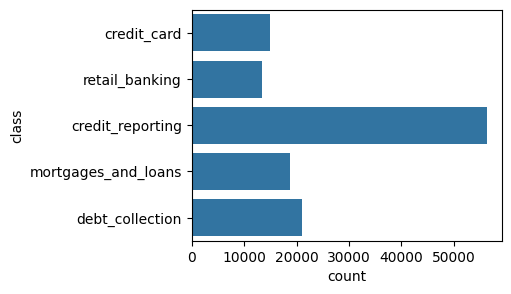

In [13]:
plt.figure(figsize=(4, 3))
sns.countplot(dataset['class'])
plt.show()

we will get a better understanding by plotting a pie chart

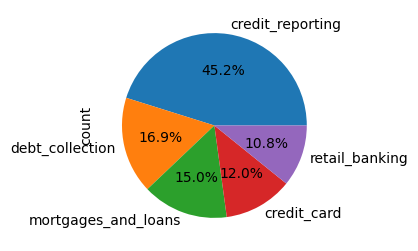

In [14]:
plt.figure(figsize=(3, 3))
dataset['class'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

**Solution:** 
Found on the internet that the possible solutions are:

    - Over-sampling the minority class
    - Under-sampling the majority class
    - Synthetic data generation
    etc.

Let's explore the complaints column now

### Length of Complaints

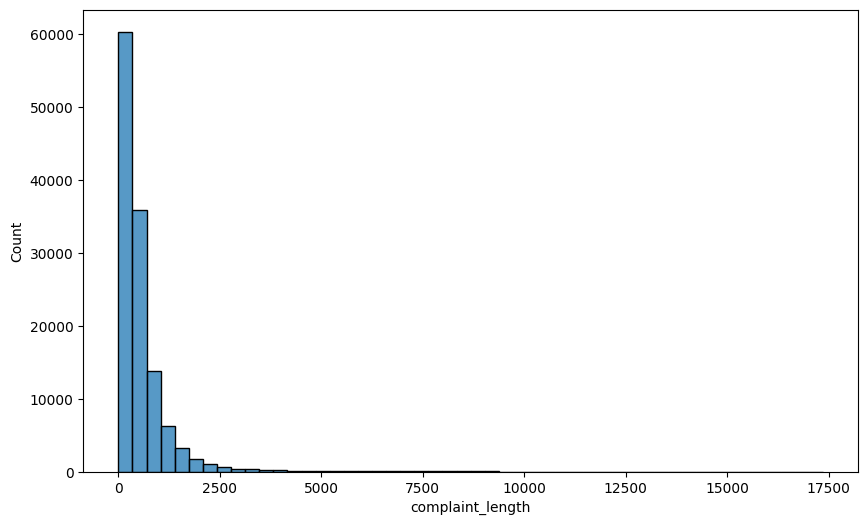

In [15]:
dataset['complaint_length'] = dataset['cleaned_complaint'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(dataset['complaint_length'], bins=50)
plt.show()

In [16]:
dataset['complaint_length'].describe()

count    124673.000000
mean        551.031522
std         713.233040
min           3.000000
25%         192.000000
50%         362.000000
75%         656.000000
max       17356.000000
Name: complaint_length, dtype: float64

from the above plot and description we see that:
    
        - the average length of complaints is around 551 words
        - the minimum length of a complaint is 3 words
        - the maximum length of a complaint is 17356 words

**conclusion**

we can see that the length of complaints is highly skewed. we will have to take care of this while building the model




how do the complaints with length 3 look like?

### word distribution

lets see the distribution of words in the complaints

In [17]:
# word distribution

dataset['word_count'] = dataset['cleaned_complaint'].apply(lambda x: len(str(x).split()))

dataset['word_count'].describe()

count    124673.000000
mean         87.096629
std         110.848837
min           1.000000
25%          30.000000
50%          58.000000
75%         104.000000
max        2684.000000
Name: word_count, dtype: float64

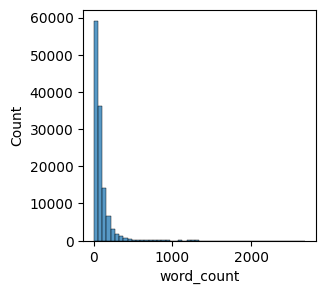

In [18]:
# plot the word count distribution
plt.figure(figsize=(3, 3))
sns.histplot(dataset['word_count'], bins=50)
plt.show()

count    124673.000000
mean         87.096629
std         110.848837
min           1.000000
25%          30.000000
50%          58.000000
75%         104.000000
max        2684.000000
Name: word_count, dtype: float64

From the above plot and description we see that:

    - the average number of words in a complaint is around 87
    - the minimum number of words in a complaint is 1
    - the maximum number of words in a complaint is 2684

**conclusion**

we can see that the number of words in complaints is highly skewed. we will have to take care of this while building the model

In [22]:
dataset.head()

,id,class,cleaned_complaint,complaint_length,word_count
0,0,credit_card,purchas order day ship amount receiv product w...,1471,230
1,1,credit_card,forward messag date tue subject pleas investig...,800,132
2,2,retail_banking,forward messag cc sent friday pdt subject fina...,1076,173
3,3,credit_reporting,payment histori miss credit report special loa...,790,131
4,4,credit_reporting,payment histori miss credit report made mistak...,752,123


In [23]:
# make list of all the words in dataset 

word_list = []

for i in dataset['cleaned_complaint']:
    for j in i.split():
        word_list.append(j)

In [24]:
# get all words and display the top words

word_list = []

for i in dataset['cleaned_complaint']:
    for j in i.split():
        word_list.append(j)

word_list[:10]

['purchas',
 'order',
 'day',
 'ship',
 'amount',
 'receiv',
 'product',
 'week',
 'sent',
 'followup']

In [25]:
# get all words and display the top words

from collections import Counter

word_freq = Counter(word_list)

word_freq.most_common(10)

[('account', 255533),
 ('credit', 242539),
 ('report', 215988),
 ('inform', 120426),
 ('payment', 118364),
 ('call', 103704),
 ('receiv', 82877),
 ('time', 76342),
 ('would', 72343),
 ('loan', 70753)]

In [26]:
word_freq.most_common()[-10:]

[('iknow', 1),
 ('forkid', 1),
 ('sept', 1),
 ('wetink', 1),
 ('descriptionqtyal', 1),
 ('tbrough', 1),
 ('yousaidmynewsinglepointofcontact', 1),
 ('faithsinceallpaymentswerepaidinfullafterthemiscommunicationbyrepswerer', 1),
 ('immediu', 1),
 ('revmd', 1)]

# lets group the complaints into classes and see the distribution of words



In [33]:
class_words = {}

for i in dataset['class'].unique():
    words = []
    for j in dataset[dataset['class'] == i]['cleaned_complaint']:
        for k in j.split():
            words.append(k)
    class_words[i] = Counter(words)

In [32]:
from wordcloud import WordCloud

def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

1. credit card

In [35]:
class_words['credit_card'].most_common(10)

[('card', 37789),
 ('credit', 33658),
 ('account', 28366),
 ('call', 19702),
 ('charg', 18422),
 ('payment', 17363),
 ('bank', 14445),
 ('receiv', 13869),
 ('would', 12966),
 ('time', 12869)]

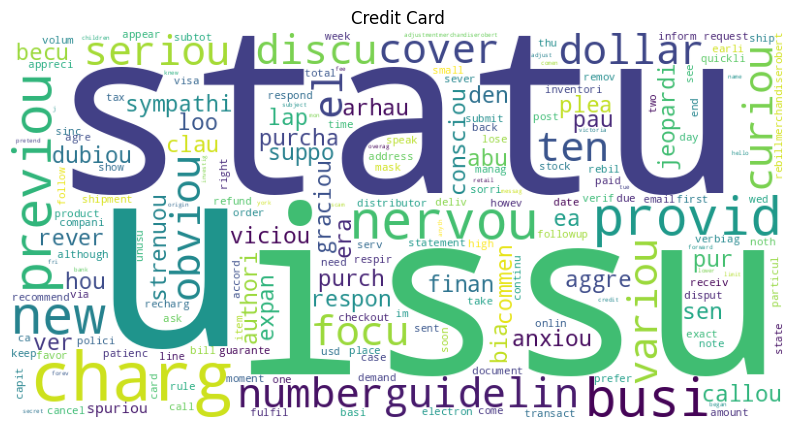

In [36]:
plot_word_cloud(' '.join(class_words['credit_card']), 'Credit Card')

2. credit reporting

In [37]:
class_words['credit_reporting'].most_common(10)

[('report', 164457),
 ('credit', 151461),
 ('account', 129860),
 ('inform', 74754),
 ('disput', 42203),
 ('remov', 39224),
 ('payment', 37369),
 ('file', 27630),
 ('date', 27215),
 ('inquiri', 27084)]

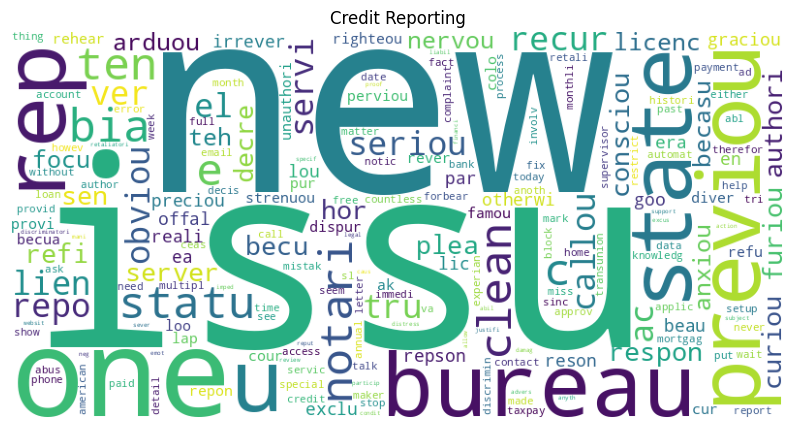

In [38]:
plot_word_cloud(' '.join(class_words['credit_reporting']), 'Credit Reporting')

3. debt collection

In [39]:
class_words['debt_collection'].most_common(10)

[('debt', 39968),
 ('credit', 35965),
 ('account', 32076),
 ('report', 31265),
 ('collect', 26930),
 ('call', 21648),
 ('compani', 17747),
 ('inform', 17217),
 ('receiv', 15680),
 ('letter', 12041)]

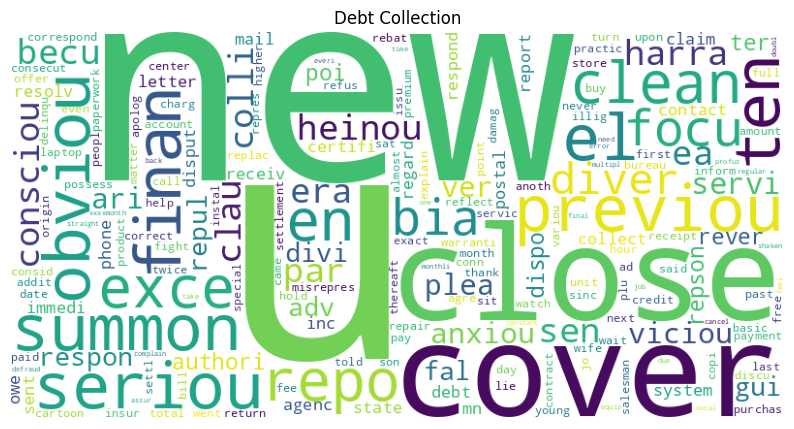

In [40]:
plot_word_cloud(' '.join(class_words['debt_collection']), 'Debt Collection')

4. mortgages and loans

In [41]:
class_words['mortgages_and_loans'].most_common(10)

[('payment', 47273),
 ('loan', 44144),
 ('call', 28109),
 ('mortgag', 26614),
 ('would', 22583),
 ('account', 19596),
 ('time', 19173),
 ('receiv', 18896),
 ('credit', 16215),
 ('told', 15635)]

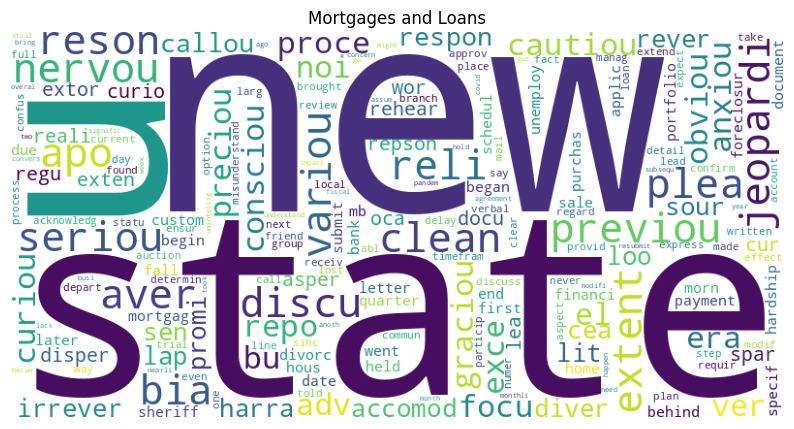

In [42]:
plot_word_cloud(' '.join(class_words['mortgages_and_loans']), 'Mortgages and Loans')

5. retail banking

In [43]:
class_words['retail_banking'].most_common(10)

[('account', 45635),
 ('bank', 27957),
 ('money', 15937),
 ('check', 15450),
 ('call', 15165),
 ('receiv', 11001),
 ('would', 10493),
 ('day', 9931),
 ('told', 9673),
 ('fund', 9509)]

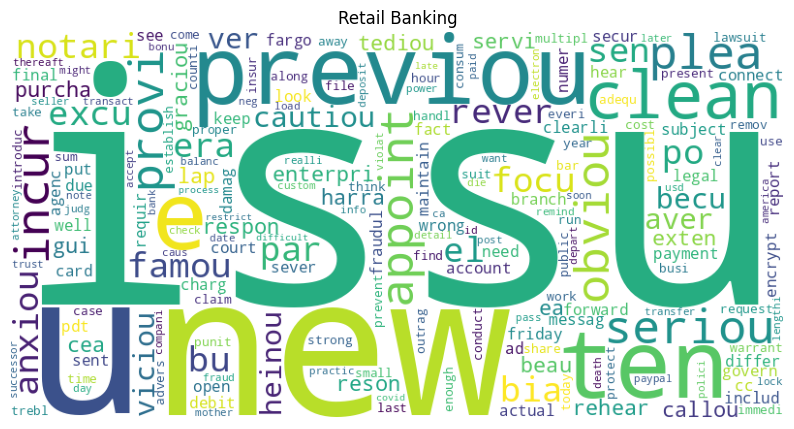

In [44]:
plot_word_cloud(' '.join(class_words['retail_banking']), 'Retail Banking')

### Now lets make models with the data we have

### Vectorizing the data to create a Bag of Words

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(dataset['cleaned_complaint'])
y = dataset['class']

### Handling Imbalanced Classes

In [6]:
# ways to handle imbalanced data
# 1. oversampling
# 2. undersampling
# 3. SMOTE

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(X, y)

### Splitting the data into training and testing sets

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

### Building the model

In [48]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

In [49]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.8434513871620901


In [50]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.8824553301836524


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


In [9]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.9373912116798693


In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

        credit_card       0.94      0.95      0.95     11297
   credit_reporting       0.91      0.89      0.90     11276
    debt_collection       0.92      0.92      0.92     11219
mortgages_and_loans       0.95      0.95      0.95     11087
     retail_banking       0.97      0.98      0.97     11423

           accuracy                           0.94     56302
          macro avg       0.94      0.94      0.94     56302
       weighted avg       0.94      0.94      0.94     56302



In [ ]:
import pickle

with open('random_forest_model_94f1.pkl', 'wb') as f:
    pickle.dump(rf, f)

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [ ]:
""" # decision tree

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print(accuracy_score(y_test, y_pred)) """

# 0.8617988703776065

In [ ]:
""" 
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(accuracy_score(y_test, y_pred))                                                                                                                               
"""                                                                                                                                                                                                            
# 0.86

In [ ]:
"""
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print(accuracy_score(y_test, y_pred))
"""

# 0.9043195623601293